<a href="https://colab.research.google.com/github/Dhanushranga1/AIW4-MambaModels/blob/main/Tumor_identificaiton_using_Mamba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Setup and Install Dependencies

In [1]:

# Install Mamba SSM for sequence modeling
!pip install -q --no-build-isolation "mamba-ssm[causal-conv1d]"

!pip install -q torchvision matplotlib tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Step 2: Data Preparation -  load only tumor containing images

In this step, we:

1 . Navigate through folders

2 . Pair images and their corresponding masks

3 . Filter out only the images with visible tumors

In [10]:
import os
import numpy as np
from PIL import Image
from glob import glob

def get_tumor_pairs_only(base_path):
    image_mask_pairs = []
    subdirs = [os.path.join(base_path, d) for d in os.listdir(base_path)
               if os.path.isdir(os.path.join(base_path, d))]

    for folder in subdirs:
        all_files = sorted(os.listdir(folder))
        for file in all_files:
            if file.endswith('.tif') and '_mask' not in file:
                mask_file = file.replace('.tif', '_mask.tif')
                image_path = os.path.join(folder, file)
                mask_path = os.path.join(folder, mask_file)

                if os.path.exists(mask_path):
                    mask = np.array(Image.open(mask_path).convert("L"))
                    if np.sum(mask > 0) > 500:
                        image_mask_pairs.append((image_path, mask_path))

    print(f" Found {len(image_mask_pairs)} tumor-positive image-mask pairs.")
    return image_mask_pairs

class BrainTumorDataset(Dataset):
    def __init__(self, image_mask_list):
        self.data = image_mask_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        image = Image.open(img_path).convert("RGB").resize((256, 256))
        mask = Image.open(mask_path).convert("L").resize((256, 256))

        image = transforms.ToTensor()(image)
        image = transforms.Normalize([0.5]*3, [0.5]*3)(image)

        mask = transforms.ToTensor()(mask)
        mask = (mask > 0.1).float()

        return image, mask



Step 2.5: Extracting Dataset from google drive

In [15]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset (run only once)
zip_path = '/content/drive/MyDrive/kaggle_3m.zip'
extract_path = '/content/kaggle_3m'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Extracted dataset to", extract_path)
else:
    print("Dataset already extracted at", extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already extracted at /content/kaggle_3m


In [17]:
from torch.utils.data import DataLoader, random_split

# Step 1: Load pairs with actual tumors
base_path = "/content/kaggle_3m/kaggle_3m"  # Update if different
image_mask_pairs = get_tumor_pairs_only(base_path)

# Step 2: Split into train/test (80/20 split)
train_size = int(0.8 * len(image_mask_pairs))
test_size = len(image_mask_pairs) - train_size
train_pairs, test_pairs = random_split(image_mask_pairs, [train_size, test_size])

# Step 3: Create datasets
train_dataset = BrainTumorDataset(train_pairs)
test_dataset = BrainTumorDataset(test_pairs)

# Step 4: Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)

print(f"Data ready: {len(train_dataset)} train, {len(test_dataset)} test samples.")


 Found 1134 tumor-positive image-mask pairs.
Data ready: 907 train, 227 test samples.




#### Step 3: Define the  Mamba-Based Segmentation Model

This model combines the efficiency of **state-space models (Mamba)** with architectural patterns inspired by **U-Net** to achieve high-resolution brain tumor segmentation.

####  Model Components and Architecture:

1. **Patch Embedding Layer**:

   * Converts the input image (`3x256x256`) into a lower-resolution, high-dimensional representation using a **convolutional patch embedding layer**.
   * The resulting tensor has shape `[B, d_model, H/patch_size, W/patch_size]`, enabling global processing while reducing spatial size.

2. **Positional Encoding**:

   * A learnable positional embedding is added to retain spatial ordering of patches for effective Mamba processing.

3. **Mamba Sequence Modeling (Encoder)**:

   * A stack of **6 Mamba blocks** is used to model long-range dependencies across patch tokens.
   * Each block is wrapped with **LayerNorm**, **Dropout**, and **residual connections**, improving training stability and representation power.

4. **Skip Connections**:

   * Skip features from the patch embedding are compressed and injected back during decoding, helping retain fine-grained spatial details (U-Net style).

5. **Decoder (Upsampling Layers)**:

   * A series of **4 transposed convolutional layers** progressively upsamples the Mamba output back to the original resolution.
   * Each layer is followed by **BatchNorm and ReLU**, improving gradient flow and convergence.

6. **Final Output Layer**:

   * A `1x1` convolution maps the last feature map to a **single-channel binary mask**, with a **sigmoid activation** applied to generate pixel-wise probabilities.

7. **Regularization & Initialization**:

   * Dropout is used after Mamba blocks to prevent overfitting.
   * Weight initialization is performed using **Kaiming Normal** for convolutions and standard practice for normalization layers.


In [31]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba

class MambaUNet(nn.Module):
    def __init__(self, image_size=256, patch_size=16, d_model=256):
        super().__init__()
        self.patch_size = patch_size
        self.d_model = d_model

        # Patch Embedding with BatchNorm for better training
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, d_model, kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(d_model),
            nn.ReLU()
        )

        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)  # Better initialization

        # Encoder Mamba Blocks with better residual connections
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(d_model),
                Mamba(d_model=d_model),
                nn.Dropout(0.1)  # Add dropout for regularization
            ) for _ in range(6)
        ])

        # Better skip connection processing
        self.skip_conv = nn.Sequential(
            nn.Conv2d(d_model, d_model//2, 1),
            nn.BatchNorm2d(d_model//2),
            nn.ReLU()
        )

        # Improved decoder with better channel handling
        self.decoder = nn.ModuleList([
            # First upsample: d_model -> 128
            nn.Sequential(
                nn.ConvTranspose2d(d_model + d_model//2, 128, 2, stride=2),  # Include skip from start
                nn.BatchNorm2d(128),
                nn.ReLU()
            ),
            # Second upsample: 128 -> 64
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, 2, stride=2),
                nn.BatchNorm2d(64),
                nn.ReLU()
            ),
            # Third upsample: 64 -> 32
            nn.Sequential(
                nn.ConvTranspose2d(64, 32, 2, stride=2),
                nn.BatchNorm2d(32),
                nn.ReLU()
            ),
            # Fourth upsample: 32 -> 16
            nn.Sequential(
                nn.ConvTranspose2d(32, 16, 2, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU()
            )
        ])

        # Final prediction layer
        self.final_conv = nn.Conv2d(16, 1, 1)

        self.dropout = nn.Dropout(0.1)  # Reduced dropout rate

        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        """Better weight initialization for stable training"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        B, _, H, W = x.shape

        # Patch embedding with better features
        x_patches = self.patch_embed(x)  # [B, d_model, 16, 16]
        skip_input = self.skip_conv(x_patches)  # [B, d_model//2, 16, 16]

        # Flatten for Mamba processing
        x = x_patches.flatten(2).transpose(1, 2) + self.pos_embed  # [B, num_patches, d_model]

        # Mamba blocks with better residual connections
        for block in self.encoder:
            residual = x
            x = block(x)
            x = x + residual  # Proper residual connection

        # Apply dropout before decoder
        x = self.dropout(x)

        # Reshape back to spatial dimensions
        x = x.transpose(1, 2).reshape(B, self.d_model, H//self.patch_size, W//self.patch_size)

        # Concatenate skip connection at the beginning
        x = torch.cat([x, skip_input], dim=1)  # [B, d_model + d_model//2, 16, 16]

        # Progressive decoding
        for decoder_layer in self.decoder:
            x = decoder_layer(x)

        # Final prediction
        x = self.final_conv(x)

        return torch.sigmoid(x)


Step 4: Loss Function and Evaluation Metrics

combined loss = bce + dice loss

In [29]:
import torch
import torch.nn.functional as F

def dice_loss(preds, targets, smooth=1.):
    preds = torch.sigmoid(preds)  # Ensure outputs are in [0,1]
    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    return 1 - ((2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth))

def combined_loss(preds, targets):
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    dice = dice_loss(preds, targets)
    return bce + dice

def dice_coef(preds, targets, threshold=0.5, smooth=1.):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    return ((2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)).item()
def iou_score(preds, targets, threshold=0.5, smooth=1.):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return ((intersection + smooth) / (union + smooth)).item()



In [33]:
import torch
from torchsummary import summary

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device:", device)

model = MambaUNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
summary(model, input_size=(3, 256, 256))


 Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]         196,864
       BatchNorm2d-2          [-1, 256, 16, 16]             512
              ReLU-3          [-1, 256, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          32,896
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         LayerNorm-7             [-1, 256, 256]             512
             Mamba-8             [-1, 256, 256]               0
           Dropout-9             [-1, 256, 256]               0
        LayerNorm-10             [-1, 256, 256]             512
            Mamba-11             [-1, 256, 256]               0
          Dropout-12             [-1, 256, 256]               0
        LayerNorm-13             [-1, 256, 256]             512
            Mamba-1



### Step 5: Model Training Loop

**Description:**
This block handles the entire training process of your Mamba-based segmentation model. It runs for a fixed number of epochs, learning from image-mask pairs to improve the accuracy of tumor segmentation.

**How it works:**

1. The model and optimizer are initialized with chosen hyperparameters (like learning rate and number of epochs).
2. For each epoch, the model is set to training mode.
3. It then loops through batches of images and corresponding masks from the training data.
4. If a mask doesn't contain any tumor (i.e., it's empty), the batch is skipped to avoid meaningless updates.
5. For valid batches:

   * The model predicts the segmentation output.
   * The combined loss (e.g., Binary Cross-Entropy + Dice Loss) is computed.
   * If the loss is invalid (NaN or Inf), the batch is skipped.
   * Otherwise, gradients are calculated and clipped to prevent instability.
   * The model weights are updated via the optimizer.
6. After going through all batches, the average loss, Dice coefficient, and Intersection-over-Union (IoU) are computed and printed for the epoch.
7. This loop repeats for the set number of epochs, gradually improving the model’s ability to identify tumors.



In [38]:
import torch.nn.utils as utils
from tqdm import tqdm

# Hyperparams
num_epochs = 35
learning_rate = 1e-4

# Model init
model = SimpleMambaSegmentation().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    model.train()
    train_loss, train_dice, train_iou = 0.0, 0.0, 0.0
    valid_batches = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, masks = images.to(device), masks.to(device)

        if masks.sum() == 0:
            continue  # skip empty mask batches to avoid NaN loss

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)

        if torch.isnan(loss) or torch.isinf(loss):
            print("Skipping batch due to NaN/Inf loss")
            continue

        loss.backward()
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Logging metrics
        train_loss += loss.item()
        train_dice += dice_coef(outputs, masks)
        train_iou += iou_score(outputs, masks)
        valid_batches += 1

    if valid_batches > 0:
        avg_loss = train_loss / valid_batches
        avg_dice = train_dice / valid_batches
        avg_iou = train_iou / valid_batches

        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f}")
    else:
        print(f"Epoch {epoch+1:02d} skipped (no valid batches with tumor)")



Epoch 1: 100%|██████████| 454/454 [00:12<00:00, 37.43it/s]


Epoch 01 | Loss: 0.8950 | Dice: 0.0200 | IoU: 0.0140


Epoch 2: 100%|██████████| 454/454 [00:12<00:00, 37.06it/s]


Epoch 02 | Loss: 0.5340 | Dice: 0.6018 | IoU: 0.4547


Epoch 3: 100%|██████████| 454/454 [00:12<00:00, 36.57it/s]


Epoch 03 | Loss: 0.4731 | Dice: 0.6414 | IoU: 0.4939


Epoch 4: 100%|██████████| 454/454 [00:11<00:00, 38.75it/s]


Epoch 04 | Loss: 0.4465 | Dice: 0.6544 | IoU: 0.5104


Epoch 5: 100%|██████████| 454/454 [00:11<00:00, 38.71it/s]


Epoch 05 | Loss: 0.4124 | Dice: 0.6809 | IoU: 0.5370


Epoch 6: 100%|██████████| 454/454 [00:11<00:00, 37.92it/s]


Epoch 06 | Loss: 0.3894 | Dice: 0.6994 | IoU: 0.5581


Epoch 7: 100%|██████████| 454/454 [00:12<00:00, 37.09it/s]


Epoch 07 | Loss: 0.3621 | Dice: 0.7204 | IoU: 0.5825


Epoch 8: 100%|██████████| 454/454 [00:12<00:00, 37.31it/s]


Epoch 08 | Loss: 0.3275 | Dice: 0.7484 | IoU: 0.6138


Epoch 9: 100%|██████████| 454/454 [00:12<00:00, 37.10it/s]


Epoch 09 | Loss: 0.3043 | Dice: 0.7671 | IoU: 0.6364


Epoch 10: 100%|██████████| 454/454 [00:12<00:00, 36.71it/s]


Epoch 10 | Loss: 0.2817 | Dice: 0.7843 | IoU: 0.6563


Epoch 11: 100%|██████████| 454/454 [00:12<00:00, 37.43it/s]


Epoch 11 | Loss: 0.2716 | Dice: 0.7910 | IoU: 0.6674


Epoch 12: 100%|██████████| 454/454 [00:11<00:00, 39.39it/s]


Epoch 12 | Loss: 0.2501 | Dice: 0.8101 | IoU: 0.6918


Epoch 13: 100%|██████████| 454/454 [00:11<00:00, 40.11it/s]


Epoch 13 | Loss: 0.2695 | Dice: 0.8210 | IoU: 0.7050


Epoch 14: 100%|██████████| 454/454 [00:12<00:00, 37.38it/s]


Epoch 14 | Loss: 0.2227 | Dice: 0.8293 | IoU: 0.7176


Epoch 15: 100%|██████████| 454/454 [00:12<00:00, 36.85it/s]


Epoch 15 | Loss: 0.2133 | Dice: 0.8369 | IoU: 0.7279


Epoch 16: 100%|██████████| 454/454 [00:12<00:00, 37.35it/s]


Epoch 16 | Loss: 0.2028 | Dice: 0.8448 | IoU: 0.7389


Epoch 17: 100%|██████████| 454/454 [00:12<00:00, 37.22it/s]


Epoch 17 | Loss: 0.1923 | Dice: 0.8530 | IoU: 0.7496


Epoch 18: 100%|██████████| 454/454 [00:12<00:00, 37.30it/s]


Epoch 18 | Loss: 0.1853 | Dice: 0.8584 | IoU: 0.7576


Epoch 19: 100%|██████████| 454/454 [00:11<00:00, 38.62it/s]


Epoch 19 | Loss: 0.1787 | Dice: 0.8635 | IoU: 0.7651


Epoch 20: 100%|██████████| 454/454 [00:11<00:00, 39.30it/s]


Epoch 20 | Loss: 0.1701 | Dice: 0.8703 | IoU: 0.7748


Epoch 21: 100%|██████████| 454/454 [00:11<00:00, 38.41it/s]


Epoch 21 | Loss: 0.1645 | Dice: 0.8743 | IoU: 0.7813


Epoch 22: 100%|██████████| 454/454 [00:12<00:00, 37.68it/s]


Epoch 22 | Loss: 0.1594 | Dice: 0.8783 | IoU: 0.7873


Epoch 23: 100%|██████████| 454/454 [00:12<00:00, 37.38it/s]


Epoch 23 | Loss: 0.1555 | Dice: 0.8812 | IoU: 0.7914


Epoch 24: 100%|██████████| 454/454 [00:12<00:00, 37.80it/s]


Epoch 24 | Loss: 0.1493 | Dice: 0.8861 | IoU: 0.7993


Epoch 25: 100%|██████████| 454/454 [00:12<00:00, 37.15it/s]


Epoch 25 | Loss: 0.1475 | Dice: 0.8873 | IoU: 0.8011


Epoch 26: 100%|██████████| 454/454 [00:12<00:00, 37.47it/s]


Epoch 26 | Loss: 0.1445 | Dice: 0.8894 | IoU: 0.8047


Epoch 27: 100%|██████████| 454/454 [00:11<00:00, 40.60it/s]


Epoch 27 | Loss: 0.1400 | Dice: 0.8929 | IoU: 0.8100


Epoch 28: 100%|██████████| 454/454 [00:11<00:00, 38.41it/s]


Epoch 28 | Loss: 0.1356 | Dice: 0.8963 | IoU: 0.8152


Epoch 29: 100%|██████████| 454/454 [00:12<00:00, 37.02it/s]


Epoch 29 | Loss: 0.1319 | Dice: 0.8991 | IoU: 0.8197


Epoch 30: 100%|██████████| 454/454 [00:12<00:00, 37.12it/s]


Epoch 30 | Loss: 0.1289 | Dice: 0.9014 | IoU: 0.8234


Epoch 31: 100%|██████████| 454/454 [00:12<00:00, 37.82it/s]


Epoch 31 | Loss: 0.1261 | Dice: 0.9033 | IoU: 0.8268


Epoch 32: 100%|██████████| 454/454 [00:12<00:00, 37.76it/s]


Epoch 32 | Loss: 0.1230 | Dice: 0.9060 | IoU: 0.8309


Epoch 33: 100%|██████████| 454/454 [00:12<00:00, 37.46it/s]


Epoch 33 | Loss: 0.1195 | Dice: 0.9087 | IoU: 0.8354


Epoch 34: 100%|██████████| 454/454 [00:11<00:00, 39.57it/s]


Epoch 34 | Loss: 0.1190 | Dice: 0.9092 | IoU: 0.8362


Epoch 35: 100%|██████████| 454/454 [00:11<00:00, 39.58it/s]

Epoch 35 | Loss: 0.1141 | Dice: 0.9131 | IoU: 0.8421


Step 6: Evaluation


In [42]:
import torch
from tqdm import tqdm

def evaluate_model(model, loader, device):
    model.eval()
    total_dice, total_iou, count = 0.0, 0.0, 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)

            if masks.sum() == 0:
                continue  # Skip empty masks

            outputs = model(images)
            total_dice += dice_coef(outputs, masks)
            total_iou += iou_score(outputs, masks)
            count += 1

    if count == 0:
        print("No valid samples found for evaluation.")
        return

    avg_dice = total_dice / count
    avg_iou = total_iou / count
    print(f"\nEvaluation Results — Dice Coefficient: {avg_dice:.4f}, IoU Score: {avg_iou:.4f}")
evaluate_model(model, test_loader, device)


Evaluating: 100%|██████████| 114/114 [00:01<00:00, 77.75it/s]


Evaluation Results — Dice Coefficient: 0.8470, IoU Score: 0.7422


Step 7: Saving the model


In [40]:
#weights save
torch.save(model.state_dict(), "mamba_segmentation_weights.pth")
print("Model weights saved to mamba_segmentation_weights.pth")
#model save
torch.save(model, "mamba_segmentation_full_model.pth")
print("Full model saved to mamba_segmentation_full_model.pth")


Model weights saved to mamba_segmentation_weights.pth
Full model saved to mamba_segmentation_full_model.pth


Step 8: Visualizing the predictions


1. **Model Prediction**: Loads one batch of test images, runs them through the trained model, and applies sigmoid + thresholding to get binary masks.

2. **Post-processing**: Moves the images, ground truth masks, and predicted masks to the CPU and formats them for visualization.

3. **Visualization**: Plots the original image, ground truth mask, and predicted mask side by side for easy comparison (for 3 samples).


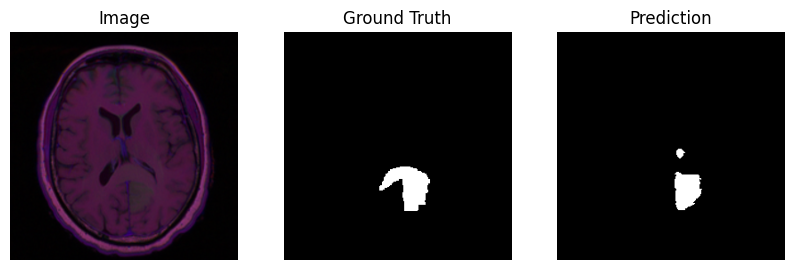

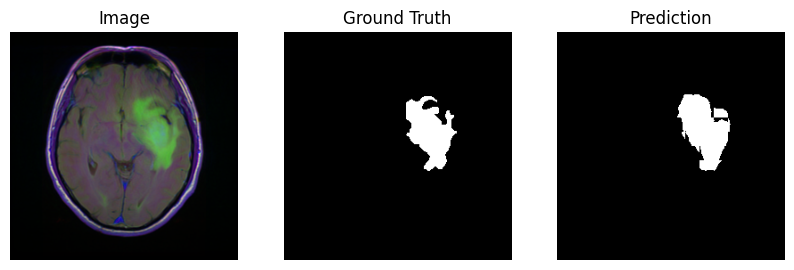

IndexError: index 2 is out of bounds for dimension 0 with size 2

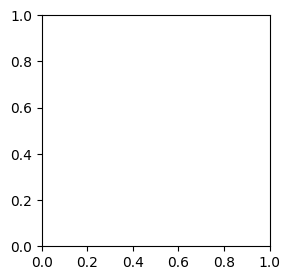

In [44]:
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    preds = model(images)

preds = (torch.sigmoid(preds) > 0.5).float()

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

def denormalize(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    return img_tensor.clamp(0, 1)

# Plot function
def show_sample(i):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    img = denormalize(images[i]).permute(1, 2, 0)  # [C,H,W] -> [H,W,C]
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i][0], cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i][0], cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# Show first 3 samples
for i in range(3):
    show_sample(i)
